# 2章 小売店のデータでデータ加工を行う

In [ ]:
!pip install japanize-matplotlib
!pip install numexpr

In [ ]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import japanize_matplotlib

work_dir = 'WORKING_DIRECTORY'

## 011. データの読み込み

In [ ]:
profit_data = pd.read_csv(f'{work_dir}/uriage.csv')
profit_data.head()

,purchase_date,item_name,item_price,customer_name
0,2019-06-13 18:02:34,商品A,100.0,深井菜々美
1,2019-07-13 13:05:29,商 品 S,NaN,浅田賢二
2,2019-05-11 19:42:07,商 品 a,NaN,南部慶二
3,2019-02-12 23:40:45,商品Z,2600.0,麻生莉緒
4,2019-04-22 03:09:35,商品a,NaN,平田鉄二


In [ ]:
customer_data = pd.read_excel(f'{work_dir}/kokyaku_daicho.xlsx')
customer_data.head()

,顧客名,かな,地域,メールアドレス,登録日
0,須賀ひとみ,すが ひとみ,H市,suga_hitomi@example.com,2018/01/04
1,岡田 敏也,おかだ としや,E市,okada_toshiya@example.com,42782
2,芳賀 希,はが のぞみ,A市,haga_nozomi@example.com,2018/01/07
3,荻野 愛,おぎの あい,F市,ogino_ai@example.com,42872
4,栗田 憲一,くりた けんいち,E市,kurita_kenichi@example.com,43127


## 012. データの揺れを可視化

In [ ]:
# item_nameのユニークな個数
profit_data['item_name'].value_counts()

商品A      133
商品S      133
商品R      133
商品P      132
商品C      130
        ... 
商品a        1
  商品W      1
商  品V      1
商品e        1
 商品P       1
Name: item_name, Length: 99, dtype: int64

In [ ]:
# item_priceの外観
profit_data['item_price'].head()

0     100.0
1       NaN
2       NaN
3    2600.0
4       NaN
Name: item_price, dtype: float64

## 013. データに揺れがある状態で集計

In [ ]:
# purchase_dateをdatetime型に変更
profit_data['purchase_date'] = pd.to_datetime(profit_data['purchase_date'])
# purchase_dateからpurchase_month列を作成
profit_data['purchase_month'] = profit_data['purchase_date'].dt.strftime('%Y/%m')
# 揺れのあるデータで集計、NaNは0に置換
aggregate_0 = pd.pivot_table(profit_data, index='purchase_month', columns='item_name', values='item_price', aggfunc='sum', fill_value=0)
aggregate_0

item_name,商品W,商 品 n,商品E,商品M,商品P,商品S,商品W,商品X,商 品O,商 品Q,商 品T,商 品V,商 品 S,商 品 a,商 品 q,商 品 s,商 品A,商 品C,商 品D,商 品E,商 品F,商 品G,商 品H,商 品I,商 品K,商 品M,商 品N,商 品O,商 品P,商 品T,商 品U,商 品V,商 品X,商 品Y,商 品s,商品 A,商品 B,商品 E,商品 F,商品 H,...,商品D,商品E,商品F,商品G,商品H,商品I,商品J,商品K,商品L,商品M,商品N,商品O,商品P,商品Q,商品R,商品S,商品T,商品U,商品V,商品W,商品X,商品Y,商品Z,商品a,商品c,商品d,商品e,商品g,商品i,商品j,商品k,商品l,商品o,商品p,商品r,商品s,商品t,商品v,商品x,商品y
purchase_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019/01,0,1400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,800,0,0,0,0,1500,1600,2000,0,0,4800,0,1900,0,0,0,0,0,...,6000,6500,7800,7000,10400,13500,16000,16500,19200,19500,21000,27000,20800,25500,36000,28500,28000,12600,41800,27600,24000,20000,0,0,300,0,0,0,0,0,1100,1200,1500,0,0,0,0,0,0,0
2019/02,0,0,0,0,0,0,0,2400,0,0,0,0,0,0,0,0,0,0,400,0,0,0,0,900,0,0,1400,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7600,5500,6600,7000,12800,8100,11000,14300,13200,16900,23800,25500,30400,30600,32400,32300,40000,37800,39600,43700,31200,20000,2600,0,0,0,0,0,0,1000,0,0,0,0,0,1900,2000,2200,0,0
2019/03,0,0,500,1300,1600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6000,4000,11400,7700,14400,10800,13000,14300,21600,26000,16800,15000,32000,34000,27000,26600,22000,46200,35200,34500,38400,35000,0,0,0,400,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2019/04,2300,0,0,0,0,0,0,0,0,1700,2000,2200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1500,0,0,0,0,0,7500,0,0,0,0,1200,0,...,7200,8000,7800,9100,7200,14400,13000,12100,15600,14300,22400,18000,22400,28900,30600,28500,28000,16800,19800,20700,38400,32500,0,0,0,0,500,700,0,0,0,0,0,0,0,1900,0,0,0,0
2019/05,0,0,0,0,0,1900,0,0,0,0,0,0,0,100,0,1900,100,0,0,0,0,0,0,0,1100,1300,0,0,0,0,0,2200,0,0,0,0,0,0,600,0,...,5200,9000,9000,14000,12000,13500,8000,15400,12000,20800,23800,24000,28800,15300,32400,20900,26000,33600,8800,36800,31200,45000,0,0,300,0,0,0,0,0,0,1200,0,0,0,0,0,0,0,2500
2019/06,0,0,0,0,0,0,2300,0,0,0,0,0,0,0,0,0,0,300,0,0,0,700,0,0,0,0,0,1500,0,0,2100,0,0,0,0,100,0,0,0,800,...,7200,6500,9600,7700,8800,12600,20000,15400,14400,19500,15400,19500,24000,23800,27000,34200,22000,29400,33000,25300,24000,30000,0,0,0,0,0,0,900,0,0,0,0,1600,0,0,0,0,2400,0
2019/07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1700,0,0,0,0,500,0,0,800,0,0,0,0,1500,0,0,0,2200,0,0,0,0,0,500,0,0,...,6000,4500,9600,11900,12800,13500,17000,9900,20400,13000,18200,25500,38400,18700,25200,38000,34000,23100,52800,32200,38400,27500,0,0,0,0,0,0,900,0,0,0,1500,0,1800,0,0,0,0,0


## 014. 商品名の揺れを補正

In [ ]:
# item_nameのユニークな個数
len(profit_data['item_name'].unique())

99

In [ ]:
# replace()でスペースを削除、upper()で半角文字を全角に変更
profit_data['item_name'] = profit_data['item_name'].map(lambda x: x.replace(' ', '').replace('　', '').upper())
profit_data['item_name'].head()

0    商品A
1    商品S
2    商品A
3    商品Z
4    商品A
Name: item_name, dtype: object

In [ ]:
len(profit_data['item_name'].unique())

26

## 015. 金額欠損値の補完

In [ ]:
# 列ごとの欠損値の個数
profit_data.isnull().sum()

purchase_date       0
item_name           0
item_price        387
customer_name       0
purchase_month      0
dtype: int64

In [ ]:
# 欠損値が含まれる行を削除し、item_nameが重複する行を削除
item_price_df = profit_data.dropna(how='any').drop_duplicates(subset='item_name').reset_index(drop=True)
item_list = list(item_price_df['item_name'])
price_list = list(item_price_df['item_price'])
# item_nameとitem_priceが対応した辞書型データ作成
item_price_dict = {}
for index, item in enumerate(item_list):
  item_price_dict[item] = price_list[index]

# 作成した辞書型データを基に欠損値を補完
profit_data['item_price'] = profit_data['item_name'].map(lambda x: item_price_dict[x])
profit_data.head(10)

,purchase_date,item_name,item_price,customer_name,purchase_month
0,2019-06-13 18:02:34,商品A,100.0,深井菜々美,2019/06
1,2019-07-13 13:05:29,商品S,1900.0,浅田賢二,2019/07
2,2019-05-11 19:42:07,商品A,100.0,南部慶二,2019/05
3,2019-02-12 23:40:45,商品Z,2600.0,麻生莉緒,2019/02
4,2019-04-22 03:09:35,商品A,100.0,平田鉄二,2019/04
5,2019-03-20 19:16:01,商品S,1900.0,堀江佑,2019/03
6,2019-05-18 19:16:53,商品A,100.0,深井照生,2019/05
7,2019-04-18 00:14:21,商品V,2200.0,牧田玲那,2019/04
8,2019-01-10 15:51:01,商品O,1500.0,堀北雅彦,2019/01
9,2019-01-28 10:47:03,商品A,100.0,大地礼子,2019/01


In [ ]:
profit_data.isnull().sum()

purchase_date     0
item_name         0
item_price        0
customer_name     0
purchase_month    0
dtype: int64

In [ ]:
# 同一のitem_nameで金額が同じか否かを調査
tmp = profit_data.groupby('item_name').agg(['min', 'max'])['item_price']
tmp['min'] == tmp['max']

item_name
商品A    True
商品B    True
商品C    True
商品D    True
商品E    True
商品F    True
商品G    True
商品H    True
商品I    True
商品J    True
商品K    True
商品L    True
商品M    True
商品N    True
商品O    True
商品P    True
商品Q    True
商品R    True
商品S    True
商品T    True
商品U    True
商品V    True
商品W    True
商品X    True
商品Y    True
商品Z    True
dtype: bool

## 016. 顧客名の揺れの補正

In [ ]:
# 補正前の顧客名の外観
customer_data.head()

,顧客名,かな,地域,メールアドレス,登録日
0,須賀ひとみ,すが ひとみ,H市,suga_hitomi@example.com,2018/01/04
1,岡田 敏也,おかだ としや,E市,okada_toshiya@example.com,42782
2,芳賀 希,はが のぞみ,A市,haga_nozomi@example.com,2018/01/07
3,荻野 愛,おぎの あい,F市,ogino_ai@example.com,42872
4,栗田 憲一,くりた けんいち,E市,kurita_kenichi@example.com,43127


In [ ]:
# replaceでスペース削除
customer_data['顧客名'] = customer_data['顧客名'].map(lambda x: x.replace(' ', '').replace('　', ''))
customer_data.head()

,顧客名,かな,地域,メールアドレス,登録日
0,須賀ひとみ,すが ひとみ,H市,suga_hitomi@example.com,2018/01/04
1,岡田敏也,おかだ としや,E市,okada_toshiya@example.com,42782
2,芳賀希,はが のぞみ,A市,haga_nozomi@example.com,2018/01/07
3,荻野愛,おぎの あい,F市,ogino_ai@example.com,42872
4,栗田憲一,くりた けんいち,E市,kurita_kenichi@example.com,43127


## 017. 登録日の揺れを補正

In [ ]:
# isdigit()で登録日が数値であるかをフラグ付け
serial_flg = customer_data['登録日'].astype('str').str.isdigit()
serial_flg

0      False
1       True
2      False
3       True
4       True
       ...  
195    False
196    False
197    False
198    False
199    False
Name: 登録日, Length: 200, dtype: bool

In [ ]:
# 登録日が数値だったデータ数
serial_flg.sum()

22

In [ ]:
# 数値から日付変換
serial_series = pd.to_timedelta(customer_data.loc[serial_flg, '登録日'].astype('float'), unit='D') + pd.to_datetime('1900/01/01')
serial_series

1     2017-02-18
3     2017-05-19
4     2018-01-29
21    2017-07-06
27    2017-06-17
47    2017-01-08
49    2017-07-15
53    2017-04-10
76    2018-03-31
80    2018-01-12
99    2017-06-01
114   2018-06-05
118   2018-01-31
122   2018-04-18
139   2017-05-27
143   2017-03-26
155   2017-01-21
172   2018-03-24
179   2017-01-10
183   2017-07-26
186   2018-07-15
192   2018-06-10
Name: 登録日, dtype: datetime64[ns]

In [ ]:
# 書式統一のため、数値でない登録日を抽出
string_series = pd.to_datetime(customer_data.loc[~serial_flg, '登録日'])
string_series

0     2018-01-04
2     2018-01-07
5     2017-06-20
6     2018-06-11
7     2017-05-19
         ...    
195   2017-06-20
196   2018-06-20
197   2017-04-29
198   2019-04-19
199   2019-04-23
Name: 登録日, Length: 178, dtype: datetime64[ns]

In [ ]:
# 数値だった登録日の行と書式統一した行を結合
customer_data['登録日'] = pd.concat([serial_series, string_series])
customer_data.head(10)

,顧客名,かな,地域,メールアドレス,登録日
0,須賀ひとみ,すが ひとみ,H市,suga_hitomi@example.com,2018-01-04
1,岡田敏也,おかだ としや,E市,okada_toshiya@example.com,2017-02-18
2,芳賀希,はが のぞみ,A市,haga_nozomi@example.com,2018-01-07
3,荻野愛,おぎの あい,F市,ogino_ai@example.com,2017-05-19
4,栗田憲一,くりた けんいち,E市,kurita_kenichi@example.com,2018-01-29
5,梅沢麻緒,うめざわ まお,A市,umezawa_mao@example.com,2017-06-20
6,相原ひとり,あいはら ひとり,H市,aihara_hitori@example.com,2018-06-11
7,新村丈史,にいむら たけし,B市,niimura_takeshi@example.com,2017-05-19
8,石川まさみ,いしかわ まさみ,G市,ishikawa_masami@example.com,2018-02-12
9,小栗正義,おぐり まさよし,G市,oguri_masayoshi@example.com,2017-07-05


In [ ]:
# 登録年月カラムを追加
customer_data['登録年月'] = customer_data['登録日'].dt.strftime('%Y/%m')
graph_data = customer_data.groupby('登録年月').count()['顧客名']
graph_data

登録年月
2017/01    15
2017/02    11
2017/03    14
2017/04    15
2017/05    13
2017/06    14
2017/07    17
2018/01    13
2018/02    15
2018/03    17
2018/04     5
2018/05    19
2018/06    13
2018/07    17
2019/04     2
Name: 顧客名, dtype: int64

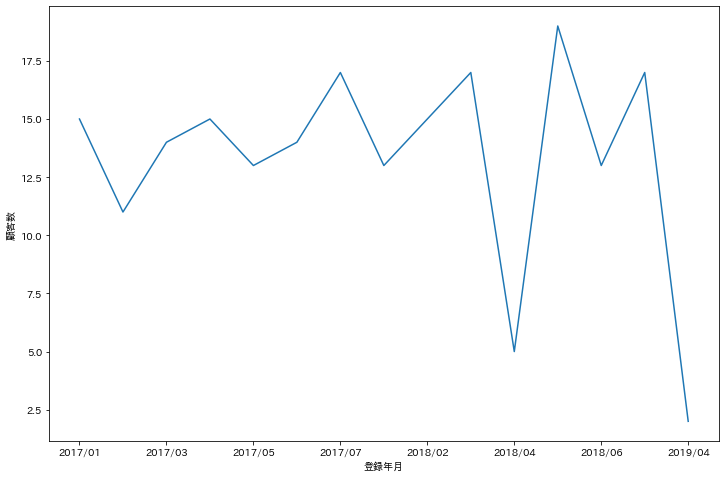

In [ ]:
# グラフ化
graph_data.plot(figsize=(12, 8), ylabel='顧客数')

## 018. 2つのデータを結合

In [ ]:
# customer_nameと顧客名をキーにして結合、customer_nameが重複するため削除
profit_customer = pd.merge(profit_data, customer_data, left_on='customer_name', right_on='顧客名', how='left').drop('customer_name', axis=1)
profit_customer.head()

,purchase_date,item_name,item_price,purchase_month,顧客名,かな,地域,メールアドレス,登録日,登録年月
0,2019-06-13 18:02:34,商品A,100.0,2019/06,深井菜々美,ふかい ななみ,C市,fukai_nanami@example.com,2017-01-26,2017/01
1,2019-07-13 13:05:29,商品S,1900.0,2019/07,浅田賢二,あさだ けんじ,C市,asada_kenji@example.com,2018-04-07,2018/04
2,2019-05-11 19:42:07,商品A,100.0,2019/05,南部慶二,なんぶ けいじ,A市,nannbu_keiji@example.com,2018-06-19,2018/06
3,2019-02-12 23:40:45,商品Z,2600.0,2019/02,麻生莉緒,あそう りお,D市,asou_rio@example.com,2018-07-22,2018/07
4,2019-04-22 03:09:35,商品A,100.0,2019/04,平田鉄二,ひらた てつじ,D市,hirata_tetsuji@example.com,2017-06-07,2017/06


## 019. データのダンプ

In [ ]:
# 列の並び替え
dump_data = profit_customer[['purchase_date', 'purchase_month', 'item_name', 'item_price', '顧客名', 'かな', '地域', 'メールアドレス', '登録日']]
dump_data.head()

,purchase_date,purchase_month,item_name,item_price,顧客名,かな,地域,メールアドレス,登録日
0,2019-06-13 18:02:34,2019/06,商品A,100.0,深井菜々美,ふかい ななみ,C市,fukai_nanami@example.com,2017-01-26
1,2019-07-13 13:05:29,2019/07,商品S,1900.0,浅田賢二,あさだ けんじ,C市,asada_kenji@example.com,2018-04-07
2,2019-05-11 19:42:07,2019/05,商品A,100.0,南部慶二,なんぶ けいじ,A市,nannbu_keiji@example.com,2018-06-19
3,2019-02-12 23:40:45,2019/02,商品Z,2600.0,麻生莉緒,あそう りお,D市,asou_rio@example.com,2018-07-22
4,2019-04-22 03:09:35,2019/04,商品A,100.0,平田鉄二,ひらた てつじ,D市,hirata_tetsuji@example.com,2017-06-07


In [ ]:
# csvへ出力
#dump_data.to_csv(f'{work_dir}/dump_data.csv', index=False)

## 020. データの集計

In [ ]:
# dump_dataの読み込み
#profit_customer = pd.read_csv(f'{work_dir}/dump_data.csv')

In [ ]:
agg_by_item = profit_customer.pivot_table(index='purchase_month', columns='item_name', aggfunc='size', fill_value=0)
agg_by_item

item_name,商品A,商品B,商品C,商品D,商品E,商品F,商品G,商品H,商品I,商品J,商品K,商品L,商品M,商品N,商品O,商品P,商品Q,商品R,商品S,商品T,商品U,商品V,商品W,商品X,商品Y,商品Z
purchase_month,,,,,,,,,,,,,,,,,,,,,,,,,,
2019/01,18,13,19,17,18,15,11,16,18,17,20,19,19,16,24,16,17,21,20,17,7,22,13,14,10,0
2019/02,19,14,26,21,16,14,14,17,12,14,16,11,15,20,19,19,22,22,22,23,19,22,24,16,11,1
2019/03,17,21,20,17,9,27,14,18,12,16,14,20,22,13,11,21,23,16,20,12,23,18,16,21,16,0
2019/04,17,19,24,20,18,17,14,11,18,13,14,15,11,20,15,15,20,20,16,16,11,15,14,16,20,0
2019/05,24,14,16,14,19,18,23,15,16,11,18,13,18,19,18,20,13,22,18,16,16,9,21,16,20,0
2019/06,24,12,11,19,13,18,15,13,19,22,15,15,17,16,15,18,15,16,21,12,18,20,17,15,13,0
2019/07,20,20,17,17,12,17,19,19,19,23,12,17,11,15,22,26,15,19,23,21,13,28,16,18,12,0


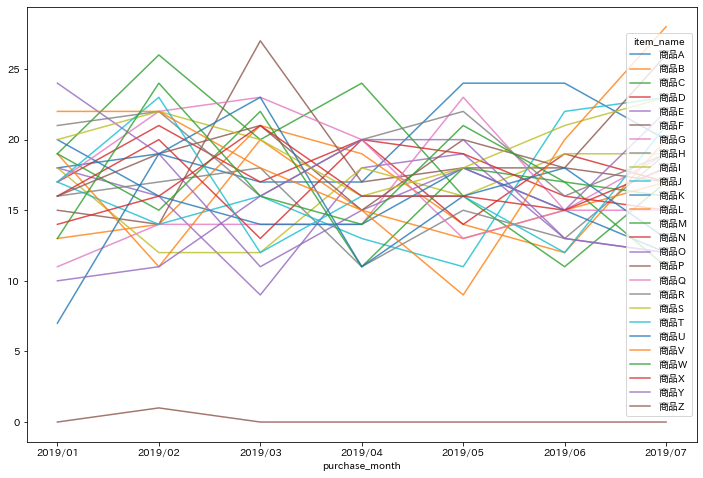

In [ ]:
agg_by_item.plot(figsize=(12, 8), alpha=0.8)

In [ ]:
agg_by_price = profit_customer.pivot_table(index='purchase_month', columns='item_name', values='item_price', aggfunc='sum', fill_value=0)
agg_by_price

item_name,商品A,商品B,商品C,商品D,商品E,商品F,商品G,商品H,商品I,商品J,商品K,商品L,商品M,商品N,商品O,商品P,商品Q,商品R,商品S,商品T,商品U,商品V,商品W,商品X,商品Y,商品Z
purchase_month,,,,,,,,,,,,,,,,,,,,,,,,,,
2019/01,1800,2600,5700,6800,9000,9000,7700,12800,16200,17000,22000,22800,24700,22400,36000,25600,28900,37800,38000,34000,14700,48400,29900,33600,25000,0
2019/02,1900,2800,7800,8400,8000,8400,9800,13600,10800,14000,17600,13200,19500,28000,28500,30400,37400,39600,41800,46000,39900,48400,55200,38400,27500,2600
2019/03,1700,4200,6000,6800,4500,16200,9800,14400,10800,16000,15400,24000,28600,18200,16500,33600,39100,28800,38000,24000,48300,39600,36800,50400,40000,0
2019/04,1700,3800,7200,8000,9000,10200,9800,8800,16200,13000,15400,18000,14300,28000,22500,24000,34000,36000,30400,32000,23100,33000,32200,38400,50000,0
2019/05,2400,2800,4800,5600,9500,10800,16100,12000,14400,11000,19800,15600,23400,26600,27000,32000,22100,39600,34200,32000,33600,19800,48300,38400,50000,0
2019/06,2400,2400,3300,7600,6500,10800,10500,10400,17100,22000,16500,18000,22100,22400,22500,28800,25500,28800,39900,24000,37800,44000,39100,36000,32500,0
2019/07,2000,4000,5100,6800,6000,10200,13300,15200,17100,23000,13200,20400,14300,21000,33000,41600,25500,34200,43700,42000,27300,61600,36800,43200,30000,0


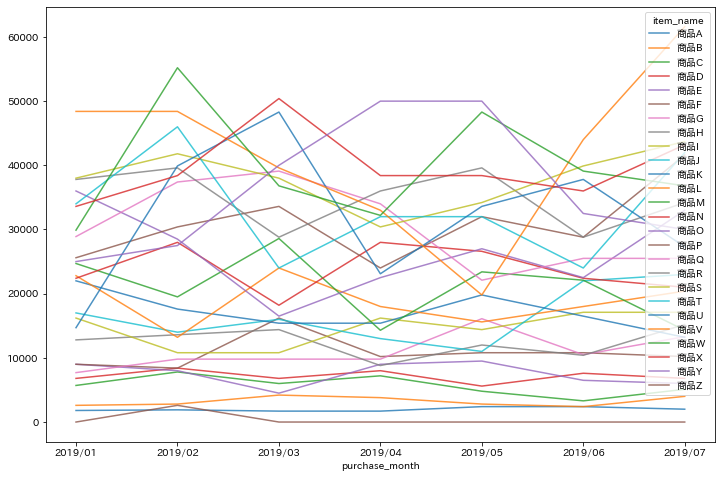

In [ ]:
agg_by_price.plot(figsize=(12, 8), alpha=0.8)

In [ ]:
agg_by_customer = profit_customer.pivot_table(index='purchase_month', columns='顧客名', aggfunc='size', fill_value=0)
agg_by_customer

顧客名,さだ千佳子,中仁晶,中田美智子,丸山光臣,久保田倫子,亀井一徳,五十嵐春樹,井上桃子,井口寛治,井川真悠子,井川里穂,井本マサカズ,井村俊二,今茜,佐藤慶二,八木雅彦,内村まさみ,内田聡,南部慶二,原口俊二,古川信吾,合田光,吉岡サダヲ,吉村愛梨,和泉直人,唐沢景子,唐沢涼,土屋朝陽,城戸芳正,堀サンタマリア,堀内聡,堀北雅彦,堀江佑,外山広司,大倉晃司,大地礼子,大城ケンイチ,大山咲,大崎ヒカル,大滝麗奈,...,福本美幸,秋葉あき,稲田将也,立石茜,笹原しぼり,笹川照生,篠山雅功,米沢仁晶,綾瀬俊介,芦田博之,芳賀希,若杉徹,荻野愛,荻野愛菜,菅原誠治,藤広之,藤木一恵,西原未華子,西島知世,西脇礼子,谷本愛梨,赤木だん吉,赤木愛梨,進藤瞬,那須蒼甫,野本仁晶,金森なつみ,鈴木一哉,青山鉄洋,須賀ひとみ,香椎優一,高原充則,高梨結衣,高沢美咲,高田さんま,鳥居広司,鶴岡薫,麻生莉緒,黄川田博之,黒谷長利
purchase_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019/01,3,1,4,2,2,0,5,3,3,1,4,1,4,3,4,4,2,1,0,4,2,1,1,2,3,1,0,1,2,2,3,1,4,6,0,4,1,3,2,3,...,1,1,2,4,0,1,1,4,4,2,1,2,3,2,4,4,0,7,1,0,2,5,3,2,2,2,2,4,2,2,0,1,1,1,5,2,0,2,2,5
2019/02,9,1,2,2,1,4,2,1,0,4,2,3,1,1,3,2,3,2,4,2,1,2,0,1,5,1,1,3,1,3,3,1,3,1,2,2,1,1,1,1,...,2,5,2,1,0,1,2,2,3,2,1,1,2,2,7,1,1,2,1,1,1,3,3,2,1,2,4,1,4,3,4,0,3,2,0,1,2,4,0,1
2019/03,1,2,1,6,1,4,3,3,2,2,1,2,0,3,2,2,3,2,1,5,1,4,2,2,0,3,4,1,0,1,5,2,5,0,1,2,1,3,2,3,...,2,2,1,1,2,5,5,1,2,1,1,0,1,2,1,5,3,1,3,2,1,3,1,1,5,2,0,1,0,2,3,1,6,2,4,2,4,2,2,1
2019/04,0,3,1,2,0,2,2,0,3,2,2,1,4,1,3,1,1,4,5,3,1,2,1,3,4,4,4,6,0,0,1,4,3,1,2,0,2,2,2,1,...,2,2,0,2,1,5,2,4,2,1,2,2,4,2,3,1,1,1,4,0,1,1,3,4,3,0,1,3,2,3,2,4,2,3,4,3,2,1,2,0
2019/05,3,2,5,2,4,1,2,1,3,3,0,3,1,1,1,3,2,1,2,1,3,1,0,6,0,0,4,3,0,2,1,1,3,0,1,0,1,2,4,4,...,6,4,0,2,1,1,2,1,4,2,1,2,4,1,1,0,5,1,2,1,4,2,4,2,0,1,1,6,2,2,1,1,1,0,2,2,3,4,4,1
2019/06,1,3,0,4,1,1,1,2,2,3,2,1,1,1,2,4,0,5,2,0,1,0,2,3,1,2,3,1,0,0,2,4,4,2,3,3,4,4,1,2,...,6,0,2,1,3,1,3,2,4,1,1,4,3,2,1,5,2,0,1,2,5,1,3,3,1,2,0,3,3,4,7,3,0,2,1,0,2,1,2,4
2019/07,3,0,3,2,5,3,5,2,5,5,6,2,0,2,1,1,3,3,0,1,2,2,2,1,2,2,2,1,1,2,0,1,1,2,1,2,1,1,1,1,...,4,3,3,1,1,1,2,2,0,2,3,4,2,1,0,1,2,1,1,4,3,4,2,3,4,3,2,0,0,4,2,4,4,2,0,2,4,3,4,1


In [ ]:
agg_by_region = profit_customer.pivot_table(index='purchase_month', columns='地域', aggfunc='size', fill_value=0)
agg_by_region

地域,A市,B市,C市,D市,E市,F市,G市,H市
purchase_month,,,,,,,,
2019/01,59,55,72,34,49,57,49,42
2019/02,71,46,65,48,61,52,43,63
2019/03,64,52,57,43,52,59,51,59
2019/04,64,48,54,45,48,58,40,52
2019/05,57,52,68,48,59,65,35,43
2019/06,53,47,61,30,51,51,58,58
2019/07,76,53,61,42,54,64,47,54


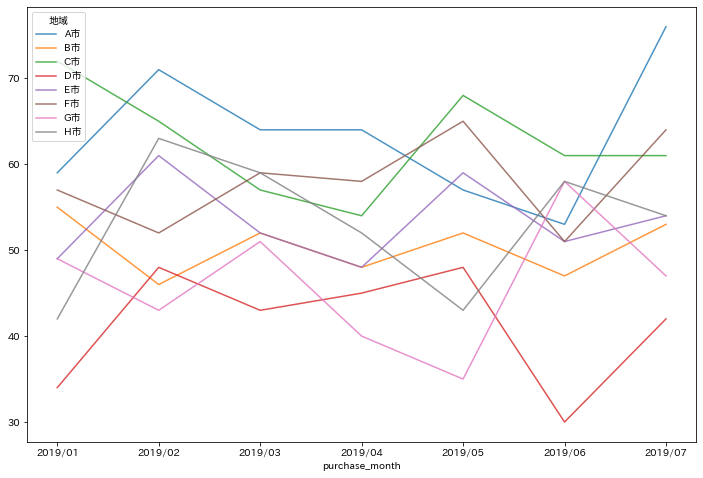

In [ ]:
agg_by_region.plot(figsize=(12, 8), alpha=0.8)